In [208]:
# Libraries
%matplotlib inline
import pandas as pd
import shapefile as shp
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd 
from geopandas.tools import sjoin # Requires build from github for correct version
from shapely import geometry
import numpy as np
import os
import pysal as ps
import random
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

DATA_DIR = 'data/'
FIGURE_DIR = 'plots/'

SHAPE_FILE = 'CENSUS2010TOWNS_SHP/CENSUS2010TOWNS_POLY.shp'
CHILD_CARE_DATA = 'data/child_care_data1.csv'
CHILD_LAT = 'Latitude'
CHILD_LONG = 'Longitude'
CENSUS_DATA = 'data/census_data.csv'
GEO_COL = 'COUSUBFP10'
POINT_PROJECTION = 4326 #Projection for lat/longs
GEOMETRY = 'geometry' # Column name for geometery data
# Default CRS assuming census tiger tracts with NAD83 projections, found from prior work
DEFAULT_CRS = {'datum': 'NAD83','k': 0.999975, 'lat_0': 36.66666666666666,'lon_0': -88.33333333333333,
 'no_defs': True,'proj': u'tmerc',u'units': u'us-ft',u'x_0': 300000, u'y_0': 0} 
    

age
count    8252.000000
mean       14.498061
std         8.102789
min         2.000000
25%         8.000000
50%        14.000000
75%        18.000000
max        36.000000
Name: age, dtype: float64 

Capacity
count    8258.000000
mean       23.396827
std        34.183666
min         0.000000
25%         6.000000
50%         8.000000
75%        24.000000
max       460.000000
Name: Capacity, dtype: float64 

eMailAddress
62.0 % of centers have logged an active eMailAddress 

MailingZipcode
14.0 % of centers have logged an active MailingZipcode 

FaxNumber
11.0 % of centers have logged an active FaxNumber 

ProviderPhone
100.0 % of centers have logged an active ProviderPhone 

Center Type

Family Child Care                        5844
Large Group and School Age Child Care    2399
Small Group and School Age Child Care      15
Name: ProgramType, dtype: int64 



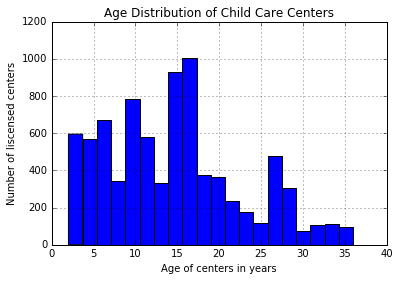

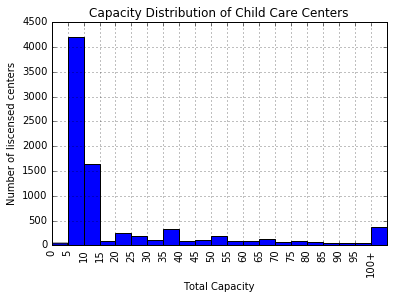

Island ids:  [117, 178]


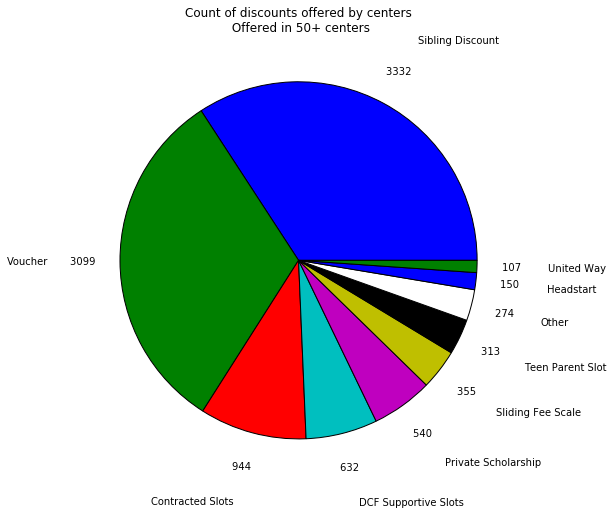

In [242]:
# Data Preparation

# Build data tied with geographic boundaries

shape_df = gpd.read_file(SHAPE_FILE)
if shape_df.crs == {}:
    shape_df = gpd.GeoDataFrame(shape_df,crs=DEFAULT_CRS)
    
shape_df[GEOMETRY] = shape_df[GEOMETRY].to_crs(epsg=POINT_PROJECTION)
shape_df = gpd.GeoDataFrame(shape_df,crs=None) #Remove crs so join completes

# Create dataframe with childcare information, remove points not in the area or null, join to town data
child_df = build_points(CHILD_CARE_DATA,CHILD_LAT,CHILD_LONG)

child_df = point_out_of_bounds(child_df,shape_df)
child_df = sjoin(child_df,shape_df,how='left')
# Get age from initial issue date
child_df['age'] = pd.to_datetime(child_df['FirstIssueDate']).apply(lambda x: pd.to_datetime('today').year - x.year) # convert age

# Split out financial assitance columns
financial_cols = dummy_list_col(child_df,'FinancialAssistance',';')
# Run analysis across child care centers
child_care_analysis(child_df,financial_cols)

# Build town level data and join in relevant data from child care dataset
census_df = join_census_files()
town_data = pd.merge(census_df,shape_df,left_on=GEO_COL.lower(),right_on=GEO_COL)
town_data.index = town_data[GEO_COL]
town_data = clean_town_data(town_data, child_df,financial_cols)



In [241]:
def clean_town_data(town_data, child_df,financial_cols):

    center_cnt = child_df.groupby([GEO_COL]).count()['ProgramName'] # count of centers
    center_cap = child_df.groupby([GEO_COL]).sum()['Capacity'] # total capacity of centers
    town_data = town_data.join(center_cnt)
    town_data = town_data.join(center_cap)
    
    # Get count of types of assistance in a town
    financial_data = child_df.groupby([GEO_COL]).sum()[financial_cols]
    
    town_data = town_data.join(financial_data)
    
    town_data.rename(columns={'ProgramName':'center_count',
                              'total_median_household_income_in_the_past_12_months_in_2014_inflation-adjusted_dollars_median_income'
                              :'total_median_income',
                             'median_income_dollars;_total_families_families_with_own_children_under_18_years_detailed_income':
                             'families_with_children_median_income'},inplace=True)
    # Convert income to int
    town_data['total_median_income'] = town_data['total_median_income'].astype(int)
    
    town_data.loc[town_data['families_with_children_median_income']=='-','families_with_children_median_income'] = 0
    town_data.loc[town_data['families_with_children_median_income']=='250,000+','families_with_children_median_income'] = 250000
    town_data['families_with_children_median_income'] = town_data['families_with_children_median_income'].astype(int)
    

    # Set towns with no entries in child care data to 0 for capacity and program name
    town_data[['Capacity','center_count']] = town_data[['Capacity','center_count']].fillna(0)

    # Add additional columns (nearby towns, age counts & proportions and race proportions)
    get_nearby_town_info(town_data)
    add_age_categories(town_data)
    add_age_proportion_columns(town_data)
    add_race_percentages(town_data)
    town_data['pop_density'] = town_data['total_population_age'].divide(town_data['SQ_MILES'])
    
    return town_data

def get_nearby_town_info(town_data):
    # Adds capacity and count of centers in nearby towns using neighbor calculation from pysal library
    num_centers = []
    capacity = []
    w = ps.weights.user.queen_from_shapefile(SHAPE_FILE,idVariable=GEO_COL)
    for town_id in town_data.index:

        neighbors = w.neighbors[town_id]

        # Get sum total of centers and capacity in neighboring towns
        capacity.append(int(town_data.ix[neighbors,['Capacity']].sum()))
        num_centers.append(int(town_data.ix[neighbors,['center_count']].sum()))
    
    town_data['nearby_capacity'] = capacity
    town_data['nearby_centers'] = num_centers
    
def add_age_proportion_columns(town_data):
    
    # rename proportion columns and created consolidated columns
    divide_cols = {'under_5':['total_age_under_5_years_age'],'5_to_9':['total_age_5_to_9_years_age'],
                   '10_to_14':['total_age_10_to_14_years_age'],
                   'under_10':['total_age_under_5_years_age','total_age_5_to_9_years_age']}


    for numerator in  ['Capacity','center_count']:
        for key, value in divide_cols.items():
            
            # add custom total column where columns are being summed
            if len(value) > 1:
                town_data[key+'_total'] = town_data[value].sum(axis=1)

            town_data[key + '_vs_' + numerator.lower()] = town_data[numerator].divide(town_data[value].sum(axis=1))
            town_data[key + '_vs_' + numerator.lower()].fillna(0,inplace=True)

def add_age_categories(town_data):
    '''
    Adds full counts of age based on given percents
    '''
    
    town_data.rename(columns={'total_total_population_age':'total_population_age'},inplace=True)
    age_categories = [x for x in town_data.columns.tolist() if ('total_age' in x) or ('selected_age' in x)]
    
    # Convert to percent
    percent_age_categories = [x.replace('total_','percent_') for x in age_categories]
    town_data[percent_age_categories] = (town_data[age_categories].astype(float) / 100)
    
    # Get population totals 
    town_data[age_categories] = town_data[percent_age_categories].multiply(town_data['total_population_age'],axis=0)

def add_race_percentages(town_data):
    '''
    Calculates percentage of race as a total of whole
    '''
                         
    town_data.rename(columns={'total__race':'total_race'},inplace=True)
    race_categories = [x for x in town_data.columns.tolist() if ('_race' in x) and ('income' not in x)]
    race_categories.remove('total_race')
    
    # Convert to percent
    percent_cols = [x.replace('total','percent') for x in race_categories]
    town_data[percent_cols] = town_data[race_categories].divide(town_data['total_race'],axis=0)
    
    # Calculate the % of non-white only in a town, American Indian and Native Hawaiian are dropped
    pct_non_white_race_cols = ['percent_black_or_african_american_alone_race','percent_asian_alone_race','percent_some_other_race_alone_race','percent_two_or_more_races:_race']
    town_data['percent_non_white_race'] = town_data[pct_non_white_race_cols].sum(axis=1)
    

In [85]:
#town_data['percent_non_white_race'] = 

town_data.columns.tolist()

['total_population_age',
 'total_age_under_5_years_age',
 'total_age_5_to_9_years_age',
 'total_age_10_to_14_years_age',
 'total_age_15_to_19_years_age',
 'total_age_20_to_24_years_age',
 'total_age_25_to_29_years_age',
 'total_age_30_to_34_years_age',
 'total_age_35_to_39_years_age',
 'total_age_40_to_44_years_age',
 'total_age_45_to_49_years_age',
 'total_age_50_to_54_years_age',
 'total_age_55_to_59_years_age',
 'total_age_60_to_64_years_age',
 'total_age_65_to_69_years_age',
 'total_age_70_to_74_years_age',
 'total_age_75_to_79_years_age',
 'total_age_80_to_84_years_age',
 'total_age_85_years_and_over_age',
 'total_selected_age_categories_5_to_14_years_age',
 'total_selected_age_categories_15_to_17_years_age',
 'total_selected_age_categories_18_to_24_years_age',
 'total_selected_age_categories_15_to_44_years_age',
 'total_selected_age_categories_16_years_and_over_age',
 'total_selected_age_categories_18_years_and_over_age',
 'total_selected_age_categories_60_years_and_over_age',
 '

In [167]:
make_binary(town_data,'Capacity',0)
no_cap = town_data.ix[town_data['Capacity_binary']==0]
cap = town_data.ix[town_data['Capacity_binary']==1]

# Capacity comparisons
print("Non-white")
t_test(no_cap['percent_non_white_race'],cap['percent_non_white_race'],'no capacity','capacity')
print("\nWhite")
t_test(no_cap['percent_white_alone_race'],cap['percent_white_alone_race'],'no capacity','capacity')

print("\nMedian Income - no children")
t_test(no_cap['total_median_income'],cap['total_median_income'],'no capacity','capacity')

print("\nMedian Income - with children")
t_test(no_cap['families_with_children_median_income'],cap['families_with_children_median_income'],'no capacity','capacity')

print("\nArea in square miles")
t_test(no_cap['SQ_MILES'],cap['SQ_MILES'],'no capacity','capacity')
print('\n',town_data.groupby(['TYPE']).mean()['Capacity_binary'])

print('\n Avg. Pop and % of towns with centers\n',
      town_data.groupby(['COUNTY']).mean()[['total_population_age','Capacity_binary']]
      .sort_values('total_population_age',ascending=False))

print('\nMedian centers in neighboring towns: ')
print('No local capacity:', no_cap['nearby_centers'].median())
print('Has local capacity:',cap['nearby_centers'].median())

print('\nMedian capacity in neighboring towns: ')
print('No local capacity:', round(no_cap['nearby_capacity'].median(),2))
print('Has local capacity:',round(cap['nearby_capacity'].median(),2))




Non-white
Means:
no capacity 0.05
capacity 0.09
Difference =  -0.05
Statisically Significant

White
Means:
no capacity 0.94
capacity 0.91
Difference =  0.04
Not Statistically Significant

Median Income - no children
Means:
no capacity 66311.15
capacity 80561.35
Difference =  -14250.2
Statisically Significant

Median Income - with children
Means:
no capacity 71346.12
capacity 101943.88
Difference =  -30597.76
Statisically Significant

Area in square miles
Means:
no capacity 24.56
capacity 22.87
Difference =  1.7
Not Statistically Significant

 TYPE
C     1.000000
T     0.888514
TC    1.000000
Name: Capacity_binary, dtype: float64

 Avg. Pop and % of towns with centers
             total_population_age  Capacity_binary
COUNTY                                           
SUFFOLK            186982.000000         1.000000
MIDDLESEX           28515.407407         1.000000
BRISTOL             27553.250000         1.000000
NORFOLK             24387.857143         1.000000
ESSEX               222

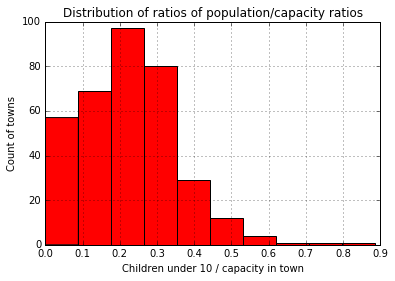

In [249]:
town_data['under_10_vs_capacity'].hist(color='r')
plt.title('Distribution of ratios of population/capacity ratios')
plt.xlabel('Children under 10 / capacity in town')
plt.ylabel('Count of towns')
plt.show()


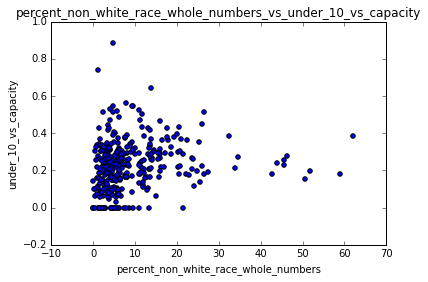

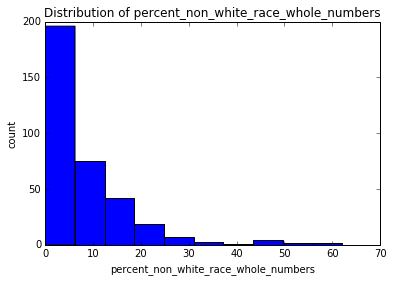

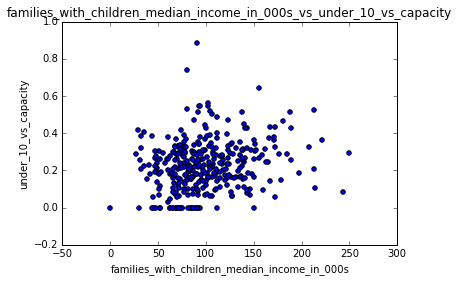

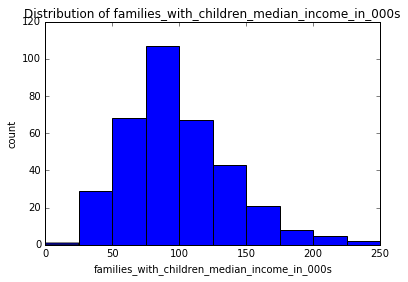

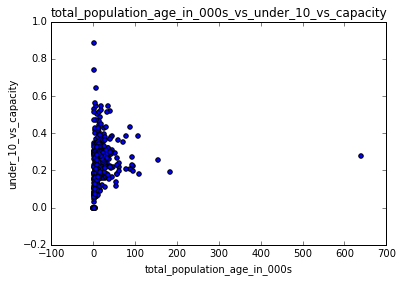

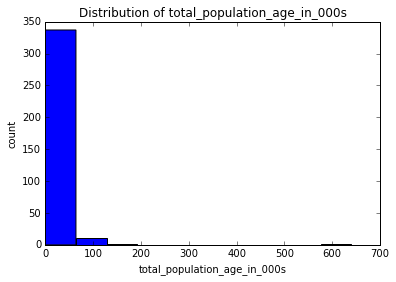

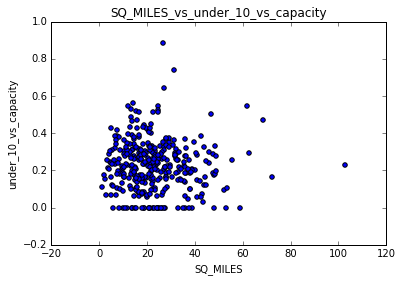

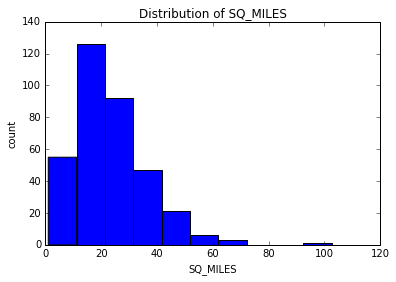

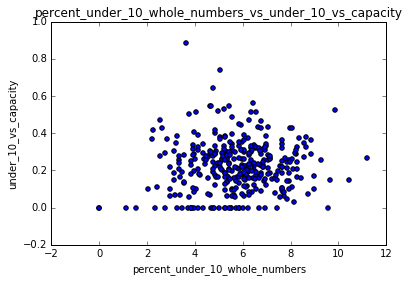

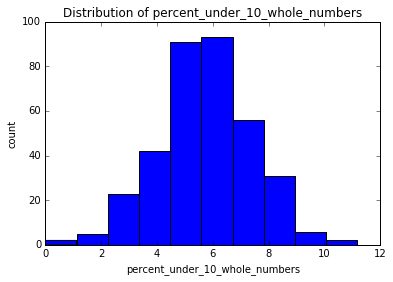

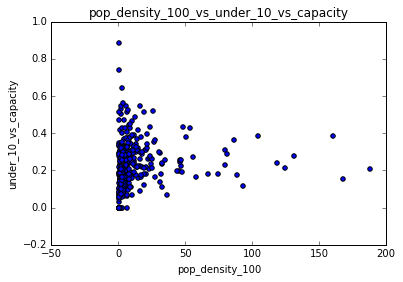

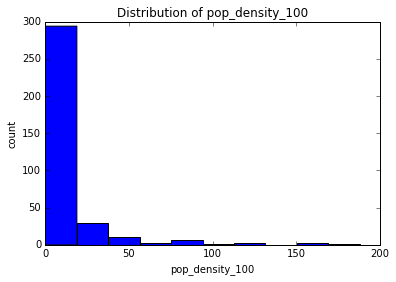

In [261]:
x_vars = ['percent_non_white_race_whole_numbers'
          ,'families_with_children_median_income_in_000s','total_population_age_in_000s',
          'SQ_MILES','percent_under_10_whole_numbers','pop_density_100']
for x in x_vars:
    plot_vars(town_data,x,'under_10_vs_capacity')


In [254]:
# Create dummies for type of town
town_type_dummies = pd.get_dummies(town_data['TYPE'])
town_type_cols = [x + '_town_type' for x in town_type_dummies.columns]
town_data[town_type_cols] = town_type_dummies

county_dummies = pd.get_dummies(town_data['COUNTY'])
county_cols = [x + '_County' for x in county_dummies.columns]
town_data[county_cols] = county_dummies

get_in_000s(town_data,'families_with_children_median_income')
get_in_000s(town_data,'total_population_age')
normalize(town_data,'under_10_vs_capacity')


town_data['percent_non_white_race_whole_numbers'] = town_data['percent_non_white_race'] * 100
town_data['percent_under_10_whole_numbers'] = town_data['percent_age_under_5_years_age'] + town_data['percent_age_5_to_9_years_age'] * 100
town_data['pop_density_100'] = town_data['pop_density'] / 100 

x_vars = ['percent_non_white_race_whole_numbers'
          ,'families_with_children_median_income_in_000s','total_population_age_in_000s',
          'SQ_MILES','percent_under_10_whole_numbers','pop_density_100']

model = sm.OLS(town_data['under_10_vs_capacity_normalized'],
               town_data[x_vars + ['T_town_type']+county_cols[:-1]])# Drop one variable to avoid collinearity
results = model.fit()
print(results.summary())

                                   OLS Regression Results                                  
Dep. Variable:     under_10_vs_capacity_normalized   R-squared:                       0.153
Model:                                         OLS   Adj. R-squared:                  0.102
Method:                              Least Squares   F-statistic:                     2.995
Date:                             Wed, 27 Apr 2016   Prob (F-statistic):           2.42e-05
Time:                                     14:58:29   Log-Likelihood:                -468.36
No. Observations:                              351   AIC:                             976.7
Df Residuals:                                  331   BIC:                             1054.
Df Model:                                       20                                         
Covariance Type:                         nonrobust                                         
                                                   coef    std err          t   

COUSUBFP10
03690     715.981563
07175     482.172522
07980     387.843335
12995     367.815562
16775     662.802451
19295     344.172658
23105     690.639664
29020     541.495499
39100     544.553443
51440     407.876327
55500     299.294774
59735     470.580290
70605      80.350606
74385     148.350501
82525     936.405275
00555     365.000854
00975      40.822184
04545      37.459178
13345     116.707344
14010     123.507818
16180     307.809610
21360      56.137388
24120      32.046120
26815     153.558232
28180      20.317145
30315      99.598145
34340     103.599222
34655     219.191248
34970     232.724913
42460      28.363276
            ...     
45105      52.950802
46820     781.141754
46925     891.745079
47135     214.847322
50670      84.410413
51825     501.991912
52420     313.101662
53120      18.706449
53225      66.853744
55395      95.849995
58580      28.941396
58825     225.880898
61800    1660.638688
63165     635.266890
63345     802.547326
66105     345.434868
67

In [230]:
def normalize(df,col):
    
    df[col+'_normalized'] = (df[col] - df[col].mean()) / df[col].std()
def make_binary(df,col,threshold):
    '''
    Adds a new binary column in
    '''
    df[col + '_binary'] = df[col] > threshold

def get_in_000s(df,col):
    df[col + '_in_000s'] = df[col] / 1000
    
def dummy_list_col(df,split_col,splitter):
    # converts a list in a cell to dummies based on the items in that list
    atom_cols = []
    for col in df[split_col]:
        try:
            # Split list and add all items that aren't already there, 
            items = col.split(splitter)
            for item in items:
                item = item.strip()
                inc = False
                for atom in atom_cols:
                    if item in atom: # String comparison to control for bad splits
                        inc = True
                        break
                if inc:
                    pass
                else:
                    atom_cols.append(item)

        except:
            pass
    
    dummies = pd.get_dummies(df[split_col])
    
    for atom_col in atom_cols:
        df[split_col + '_' + atom_col] = dummies[[x for x in dummies.columns if atom_col in x]].sum(axis=1)
    
    return [split_col + '_' + col for col in atom_cols]


In [260]:
def plot_vars(df,x_col,y_col):
    title = x_col + '_vs_' + y_col
    plt.scatter(df[x_col],df[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.savefig(FIGURE_DIR + title + '.png')
    plt.show()
    plt.hist(df[x])
    plt.title('Distribution of ' + x_col)
    plt.xlabel(x_col)
    plt.ylabel('count')
    plt.savefig(FIGURE_DIR + x_col + '_decription.png')
    plt.show()
    
def draw_relative_map(col_name,town_data,title,color):
    col = town_data[col_name]
    rank_col = col.rank() 
    col_name = col_name + '_rank'
    town_data[col_name] = (rank_col / rank_col.max()).apply(lambda x: 1 - round(x,2))

    plt.figure()


    low_patch = mpl.patches.Patch(fill=False,edgecolor='k', label='Lowest Ratio (10th percentile)')
    medium_patch = mpl.patches.Patch(color=color,alpha=.5, label='Median Ratio')
    high_patch = mpl.patches.Patch(color=color,alpha=1, label='Highest Ratio (90+ percentile)')
    plt.legend(handles=[low_patch,medium_patch,high_patch],loc=3)


    for row, shape in enumerate(town_data['geometry']):
        alpha = town_data.ix[row,col_name]
        try:
            x,y = shape.exterior.coords.xy
        except:
            shape_list = list(shape)
            for sub_shape in shape_list:
                x,y = sub_shape.exterior.coords.xy
                plt.fill(x,y,color=color,alpha=alpha)

        plt.fill(x,y,color=color,alpha=alpha)
    plt.gcf().set_size_inches(14,8)
    plt.title(title)
    plt.axis('off')
    plt.savefig(FIGURE_DIR + title + '.png')
    plt.show()

def child_care_analysis(df,financial_cols):
    '''
    Runs custom analysis on child care data, description statistics and graphing
    '''   
    
    
    # Basic statistics on key categories
    cols = ['age','Capacity','eMailAddress','MailingZipcode','FaxNumber','ProviderPhone']
    for col in cols:
        print(col)
        if df[col].dtype == 'O' or col == 'FaxNumber':
            print(round(df[col].count()/len(df[col]),2)*100,
                  '% of centers have logged an active', col,'\n')
        else:
            print(df[col].describe(),'\n')
            
         
    # Print information about type
    print("Center Type\n")
    print(child_df['ProgramType'].value_counts(),'\n')
    
          
    # Graph age distribution
    
    df['age'].hist(bins=20)
    plt.title("Age Distribution of Child Care Centers")
    plt.xlabel("Age of centers in years")
    plt.ylabel("Number of liscensed centers")
    plt.savefig(FIGURE_DIR + "age_distribution.png")
    plt.show()
    
        
    # graph capacity with cutoff bin at 100
    data = df['Capacity'].copy()
    cut_off = 100
    step = 5
    bins = list(range(0,cut_off+step*2,step))
    data[data > cut_off] = cut_off+1
    data.hist(bins=bins)
    plt.title("Capacity Distribution of Child Care Centers")
    plt.xlabel("Total Capacity")
    plt.ylabel("Number of liscensed centers")
    plt.xlim([0,cut_off+step])
    plt.xticks(bins,bins[:-2]+[str(cut_off)+'+',''],rotation=90)
    plt.savefig(FIGURE_DIR + "capacity_distribution.png")
    plt.show()
    
    # Analyze financial assistance
    
    
    # Get ordered list of types of financial assistance
    sorted_df = df[financial_cols].sum().sort_values(ascending=False)
    sorted_df = sorted_df[sorted_df > 50] # Drop all assistance less than 50 (<5 types)
    
    # plot
    labels = [x.replace("FinancialAssistance_",'') for x in sorted_df.index]
    plt.figure(1, figsize = (12, 8))
    plt.axes(aspect = 1)
    plt.pie(list(sorted_df),labels=labels,startangle = 0,
       labeldistance = 1.4,autopct = lambda x: '{:.0f} '.format(x * sum(sorted_df) / 100,x),pctdistance = 1.2)
    
    plt.title('Count of discounts offered by centers\n Offered in 50+ centers')
    plt.savefig(FIGURE_DIR + "discount_types.png")
    
    

In [6]:
def get_dataset_name(filename):
    # returns name for use in columns of final dataframe
    return os.path.basename(filename).replace('.csv','').replace('census_','')
    
def join_census_files():
    # Loops through all files and merges on geoid
    cen_files = [DATA_DIR  + x for x in os.listdir(DATA_DIR) if 'census' in x]

    df = pd.read_csv(cen_files[0],index_col='Id')
    data_set_name = get_dataset_name(cen_files[0])
    df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)    
    for filename in cen_files[1:]:
        new_df = pd.read_csv(filename,index_col='Id')
        data_set_name = get_dataset_name(filename)
        new_df.rename(columns=lambda x: x+'_'+data_set_name,inplace=True)
        
        df = df.join(new_df,how='left')
    
    return clean_census_data(df)

def clean_census_data(census_df):
    
    # Get town ID out of census provided ID
    census_df[GEO_COL] = [x[-5:] for x in census_df.index.tolist()]
    
    # Drop columns, margin of error, gender, information on imputation
    error_cols = [x for x in census_df.columns if 'Margin of Error' in x]
    # Gender
    gender_cols = [x for x in census_df.columns if ('Female;' in x) or ('Male;' in x)]
    # Imputation
    impute_cols = [x for x in census_df.columns if 'imputed' in x.lower()]
    # ID cols
    id_cols = [x for x in census_df.columns if ('Id2' in x) or ('Geography' in x)]
    # Drop
    census_df.drop(error_cols+gender_cols+impute_cols+id_cols,axis=1,inplace=True)
    
    # Make names uniform and reduce text
    census_df.rename(columns=lambda x: x.replace('Total; Estimate;','total')
                     .replace('Estimate; Total: - ','total_').replace('Estimate; Total:','total_').replace('Estimate; ','total_')
                     .replace('Median income (dollars); Estimate;','median_income'),inplace=True)
    census_df.rename(columns=lambda x:x.replace(' - ','_').replace(' ','_').replace('--','').replace('(','').replace(')','').
                     replace(',','').lower(),inplace=True)

    
    return census_df

In [155]:
def town_analysis(town_data):
    cap_col_name = 'under_10_vs_capacity'
    cap_title = 'Relative Rankings of Ratios of Eligible Population to Capacity'
    cap_color = 'b'
    draw_relative_map(cap_col_name,town_data,cap_title,cap_color)

    cnt_col_name = 'under_10_vs_center_count'
    cnt_title = 'Relative Rankings of Ratios of Eligible Population to # of Centers'
    cnt_color = 'g'
    draw_relative_map(cnt_col_name,town_data,cnt_title,cnt_color)
    

def t_test(col1,col2,name1,name2):
    print("Means:")
    print(name1,round(col1.mean(),2))
    print(name2,round(col2.mean(),2))
    print('Difference = ',round(col1.mean()-col2.mean(),2))
    
    if stats.ttest_ind(col1,col2)[0] < .05:
        print("Statisically Significant")
    else:
        print("Not Statistically Significant")


In [8]:
def build_points(filename,lat,long):
    '''
    Creates dataframe from file to join to shapefile
    '''
    point_df = pd.read_csv(filename)
    point_df = gpd.GeoDataFrame(point_df)
    #Add Points to df
    point_list = []
    for index, row in point_df.iterrows():
        point_list.append(geometry.Point(row[long],row[lat]))
    point_df[GEOMETRY] = point_list
    return point_df

def point_out_of_bounds(point_df, shape_df):
    '''
    Drops points that aren't in the bounded area or are Null
    '''
    minx, miny, maxx, maxy = shape_df.total_bounds
    #Drop Null & out of range points
    return point_df[(point_df[CHILD_LAT] > miny) & (point_df[CHILD_LAT] < maxy) & (point_df[CHILD_LONG] > minx) & (point_df[CHILD_LONG] < maxx)] 
    
